# Orders Forecasting Challenge

## References

## Import Python Libraries

In [792]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from scipy.stats import boxcox, boxcox_normplot
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif, RFE, SelectFromModel
from sklearn.preprocessing import LabelEncoder, StandardScaler, RobustScaler, MinMaxScaler, OneHotEncoder, OrdinalEncoder
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import explained_variance_score, r2_score, mean_squared_error, mean_absolute_error, median_absolute_error
import requests
import datetime as dt

# Import Notebook Functions

In [793]:
# get regression metric functions from stored python file
filepath = "https://raw.githubusercontent.com/notfakearcher/julian/main/01_practice/machine_learning/supervised_learning/regression/regression_metrics.py"
request = requests.get(filepath)
with open("regression_metrics.py", "wb") as f:
  f.write(request.content)
from regression_metrics import jra_regression_metrics

## Global Variables

In [794]:
# random state seed for repeatability
random_state = 4781

# colors
c1 = 'grey'
c2 = 'red'
c3 = 'blue'

# root folder
# root_folder = 'c:/Users/80148956/Desktop/Upskill/github_repositories/julian/04_projects/orders_forecasting/'
root_folder = 'https://raw.githubusercontent.com/notfakearcher/julian/main/04_projects/orders_forecasting/'

# data folder
data_folder = root_folder + 'data/'

## Import Dataset

In [795]:
# Source: 
# 1. ....

# Dataset Column Overview: 
# ------------------------------------------------------------------------------

# X01: 
# X02: 
# X03: 
# X04: 
# X05: 
# X06: 
# X07: 
# X08: 
# X09: 
# X10: 
# X11: 
# X12: 
# X13: 
# X14: 
# X15: 
# X16: 
# X17: 
# X18: 
# X19: 
# X20: 
# X21: 
# X22: 
# X23: 
# X24: 
# X25: 
#   y: 


In [796]:
# load train.csv
filepath1 = data_folder + 'train.csv'
df_train = pd.read_csv(filepath1, header = 0)
df_train.sample(5)

,warehouse,date,orders,holiday_name,holiday,shutdown,mini_shutdown,shops_closed,winter_school_holidays,school_holidays,blackout,mov_change,frankfurt_shutdown,precipitation,snow,user_activity_1,user_activity_2,id
3865,Prague_3,9/18/2021,4159,NaN,0,0,0,0,0,0,0,0.0,0,0.00,0.00,955,16717,Prague_3_2021-09-18
4524,Prague_3,7/11/2023,4542,NaN,0,0,0,0,0,0,0,0.0,0,0.10,0.00,947,19523,Prague_3_2023-07-11
3945,Prague_3,12/7/2021,4826,NaN,0,0,0,0,0,0,0,0.0,0,0.00,0.12,1005,20332,Prague_3_2021-12-07
1438,Brno_1,8/8/2021,5402,NaN,0,0,0,0,0,0,0,0.0,0,11.70,0.00,2269,25322,Brno_1_2021-08-08
6811,Budapest_1,9/15/2022,5340,NaN,0,0,0,0,0,0,0,0.0,0,4.15,0.00,2964,21603,Budapest_1_2022-09-15


In [797]:
# load train_calendar.csv
filepath1 = data_folder + 'train_calendar.csv'
df_train_calendar = pd.read_csv(filepath1, header = 0)

# add id column
df_train_calendar['id'] = df_train_calendar['warehouse'] + "_" + df_train_calendar['date']
df_train_calendar.sample(5)

,date,holiday_name,holiday,shutdown,mini_shutdown,warehouse_limited,shops_closed,winter_school_holidays,school_holidays,blackout,mov_change,frankfurt_shutdown,precipitation,snow,warehouse,id
6437,2020-12-20,NaN,0,0,0,0,0,0,0,0,0.0,0,NaN,NaN,Prague_3,Prague_3_2020-12-20
1645,2020-02-13,NaN,0,0,0,0,0,0,0,0,0.0,0,0.2,0.0,Prague_1,Prague_1_2020-02-13
5888,2022-08-20,NaN,0,0,0,0,0,0,0,0,0.0,0,62.0,0.0,Prague_3,Prague_3_2022-08-20
11674,2020-03-01,NaN,0,0,0,0,0,0,0,0,0.0,0,0.0,0.0,Budapest_1,Budapest_1_2020-03-01
3699,2021-04-02,Good Friday,1,0,0,0,0,0,0,0,0.0,0,0.0,0.0,Brno_1,Brno_1_2021-04-02


In [798]:
# left join train and train_calendar
df_all = pd.merge(df_train, df_train_calendar, on = 'id', how = 'left')

# order columns
ordered_cols = np.sort(df_all.columns)
df_all = df_all[ordered_cols]

# replace object columns that are null with ''
object_cols = df_all.select_dtypes(include = 'object').columns.copy()
cond = df_all.loc[:, object_cols].isna()
df_all[cond] = ''

# replace numeric columns that are null with 0
number_cols = df_all.select_dtypes(include = 'number').columns.copy()
cond = df_all.loc[:, number_cols].isna()
df_all[cond] = 0

df_all.sample(5)

,blackout_x,blackout_y,date_x,date_y,frankfurt_shutdown_x,frankfurt_shutdown_y,holiday_name_x,holiday_name_y,holiday_x,holiday_y,...,shutdown_y,snow_x,snow_y,user_activity_1,user_activity_2,warehouse_limited,warehouse_x,warehouse_y,winter_school_holidays_x,winter_school_holidays_y
764,0,0,1/11/2023,2023-01-11,0,0,,,0,0,...,0,0.0,0.0,1640,40664,0,Prague_1,Prague_1,0,0
2146,0,0,7/19/2023,2023-07-19,0,0,,,0,0,...,0,0.0,0.0,2291,30235,0,Brno_1,Brno_1,0,0
3923,0,0,11/15/2021,2021-11-15,0,0,,,0,0,...,0,0.0,0.0,988,19090,0,Prague_3,Prague_3,0,0
3522,0,0,1/19/2024,2024-01-19,0,0,,,0,0,...,0,1.0,1.0,1321,26205,0,Prague_2,Prague_2,0,0
215,0,0,7/9/2021,2021-07-09,0,0,,,0,0,...,0,0.0,0.0,1644,31973,0,Prague_1,Prague_1,0,0


In [799]:
# get columns with x in name
x_cols = df_all.filter(like = 'x').columns

for x_col in x_cols:
  # get y_col
  y_col = re.sub(pattern = 'x', repl = 'y', string = x_col)

  # check where x_col and y_col do not match in dataframe
  cond = df_all[x_col] != df_all[y_col]
  
  # replace where does not match with max value
  df_all.loc[cond, x_col] = np.max(df_all[[x_col, y_col]], axis = 1)
  
  # add new column
  new_col = re.sub(pattern = '_x', repl = '', string = x_col)
  df_all[new_col] = df_all[x_col]
  
  # drop existing x_col and y_col
  df_all = df_all.drop([x_col, y_col], errors = 'ignore', axis = 1)

# order columns
ordered_cols = np.sort(df_all.columns)
df_all = df_all[ordered_cols]

df_all.sample(5)

,blackout,date,frankfurt_shutdown,holiday,holiday_name,id,mini_shutdown,mov_change,orders,precipitation,school_holidays,shops_closed,shutdown,snow,user_activity_1,user_activity_2,warehouse,warehouse_limited,winter_school_holidays
1532,0,2021-11-10,0,0,,Brno_1_2021-11-10,0,0.0,7552,0.0,0,0,0,0.0,2437,30616,Brno_1,0,0
4454,0,5/2/2023,0,0,,Prague_3_2023-05-02,0,1.0,4830,0.2,0,0,0,0.0,931,20191,Prague_3,0,0
175,0,5/30/2021,0,0,,Prague_1_2021-05-30,0,0.0,6649,0.0,0,0,0,0.0,1620,32383,Prague_1,0,0
3236,0,4/7/2023,0,1,Good Friday,Prague_2_2023-04-07,0,1.0,6109,1.0,0,0,0,0.0,1294,22408,Prague_2,0,0
4677,0,2023-12-11,0,0,,Prague_3_2023-12-11,0,0.0,5335,0.1,0,0,0,0.0,955,21894,Prague_3,0,0


## Feature Engineering

In [800]:
# convert date text column to date type
df_all['date'] = df_all['date'].astype('datetime64[ns]')
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7340 entries, 0 to 7339
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   blackout                7340 non-null   int64         
 1   date                    7340 non-null   datetime64[ns]
 2   frankfurt_shutdown      7340 non-null   int64         
 3   holiday                 7340 non-null   int64         
 4   holiday_name            7340 non-null   object        
 5   id                      7340 non-null   object        
 6   mini_shutdown           7340 non-null   int64         
 7   mov_change              7340 non-null   float64       
 8   orders                  7340 non-null   int64         
 9   precipitation           7340 non-null   float64       
 10  school_holidays         7340 non-null   int64         
 11  shops_closed            7340 non-null   int64         
 12  shutdown                7340 non-null   int64   

In [801]:
# get column for day
df_all['day'] = df_all['date'].dt.day

# get column for month
df_all['month'] = df_all['date'].dt.month

# get column for year
df_all['year'] = df_all['date'].dt.year

# get column for weekday
df_all['weekday'] = df_all['date'].dt.weekday + 1

# get column for day of year
df_all['day_of_year'] = df_all['date'].dt.dayofyear

# get column for quarter
df_all['quarter'] = df_all['date'].dt.quarter

# get column for is leap year
df_all['is_leap_year'] = df_all['date'].dt.is_leap_year.astype('int')

# order columns
ordered_cols = np.sort(df_all.columns)
df_all = df_all[ordered_cols]

df_all.sample(5)

,blackout,date,day,day_of_year,frankfurt_shutdown,holiday,holiday_name,id,is_leap_year,mini_shutdown,...,shops_closed,shutdown,snow,user_activity_1,user_activity_2,warehouse,warehouse_limited,weekday,winter_school_holidays,year
3939,0,2021-12-01,1,335,0,0,,Prague_3_2021-12-01,0,0,...,0,0,0.0,988,20023,Prague_3,0,3,0,2021
355,0,2021-11-26,26,330,0,0,,Prague_1_2021-11-26,0,0,...,0,0,0.0,1873,38865,Prague_1,0,5,0,2021
2701,0,2021-10-17,17,290,0,0,,Prague_2_2021-10-17,0,0,...,0,0,0.0,1307,20332,Prague_2,0,7,0,2021
2488,0,2021-03-18,18,77,0,0,,Prague_2_2021-03-18,0,0,...,0,0,0.0,1367,20717,Prague_2,0,4,0,2021
111,0,2021-03-27,27,86,0,0,,Prague_1_2021-03-27,0,0,...,0,0,0.0,1735,35212,Prague_1,0,6,0,2021


In [802]:
# add levels for user activity
factor = 400
df_all['user_activity_1_levels'] = (df_all['user_activity_1'] // factor).astype('int')
df_all.sample(5)

,blackout,date,day,day_of_year,frankfurt_shutdown,holiday,holiday_name,id,is_leap_year,mini_shutdown,...,shutdown,snow,user_activity_1,user_activity_2,warehouse,warehouse_limited,weekday,winter_school_holidays,year,user_activity_1_levels
1211,0,2020-12-23,23,358,0,0,,Brno_1_2020-12-23,1,0,...,0,0.0,2386,27014,Brno_1,0,3,0,2020,5
6146,0,2024-01-30,30,30,0,0,,Frankfurt_1_2024-01-30,1,0,...,0,0.0,822,7279,Frankfurt_1,0,2,0,2024,2
1907,0,2022-11-21,21,325,0,0,,Brno_1_2022-11-21,0,0,...,0,0.0,2306,29564,Brno_1,0,1,0,2022,5
2218,0,2023-09-29,29,272,0,0,,Brno_1_2023-09-29,0,0,...,0,0.0,2339,32049,Brno_1,0,5,0,2023,5
6047,0,2023-10-02,2,275,0,0,,Frankfurt_1_2023-10-02,0,0,...,0,0.0,824,6573,Frankfurt_1,0,1,0,2023,2


In [803]:
# transform precipitation using convenient optimal box-cox transformation
fudge_factor = 0.001
temp = df_all['precipitation'] + fudge_factor
fitted_data, lamda = boxcox(x = temp)
df_all['precipitation_lamda_0'] = boxcox(x = temp, lmbda = lamda.round())

# add levels for precipitation_lamda_0 levels
temp = df_all['precipitation_lamda_0'].min() + df_all['precipitation_lamda_0']
factor = temp.mean()
df_all['precipitation_levels'] = (temp // factor).astype('int')
df_all.sample(5)

,blackout,date,day,day_of_year,frankfurt_shutdown,holiday,holiday_name,id,is_leap_year,mini_shutdown,...,user_activity_1,user_activity_2,warehouse,warehouse_limited,weekday,winter_school_holidays,year,user_activity_1_levels,precipitation_lamda_0,precipitation_levels
711,0,2022-11-18,18,322,0,0,,Prague_1_2022-11-18,0,0,...,1656,36851,Prague_1,0,5,0,2022,4,1.029976,0
863,0,2023-04-20,20,110,0,0,,Prague_1_2023-04-20,0,0,...,1628,38460,Prague_1,0,4,0,2023,4,-0.221894,0
2935,0,2022-06-09,9,160,0,0,,Prague_2_2022-06-09,0,0,...,1281,20338,Prague_2,0,4,0,2022,3,0.824614,0
6797,0,2022-09-01,1,244,0,0,,Budapest_1_2022-09-01,0,0,...,2949,21561,Budapest_1,0,4,0,2022,7,1.749374,0
77,0,2021-02-21,21,52,0,0,,Prague_1_2021-02-21,0,0,...,1794,33964,Prague_1,0,7,0,2021,4,-6.907755,1


In [804]:
# transform snow using convenient optimal box-cox transformation
temp = df_all['snow'] + fudge_factor
fitted_data, lamda = boxcox(x = temp)
df_all['snow_lamda_m2'] = boxcox(x = temp, lmbda = lamda.round())

# add levels for snow_lamda_0 levels
temp = df_all['snow_lamda_m2'].min() + df_all['snow_lamda_m2']
factor = temp.mean()
df_all['snow_levels'] = (temp // factor).astype('int')
df_all.sample(5)

,blackout,date,day,day_of_year,frankfurt_shutdown,holiday,holiday_name,id,is_leap_year,mini_shutdown,...,warehouse,warehouse_limited,weekday,winter_school_holidays,year,user_activity_1_levels,precipitation_lamda_0,precipitation_levels,snow_lamda_m2,snow_levels
5327,0,2023-06-17,17,168,0,0,,Munich_1_2023-06-17,0,0,...,Munich_1,0,6,0,2023,1,-0.818710,0,-499999.5,1
5985,0,2023-07-21,21,202,0,0,,Frankfurt_1_2023-07-21,0,0,...,Frankfurt_1,0,5,0,2023,2,-6.907755,1,-499999.5,1
5510,0,2024-01-22,22,22,0,0,,Munich_1_2024-01-22,1,0,...,Munich_1,0,1,0,2024,1,1.754577,0,-499999.5,1
5296,0,2023-05-09,9,129,0,0,,Munich_1_2023-05-09,0,0,...,Munich_1,0,2,0,2023,1,-0.691149,0,-499999.5,1
5258,0,2023-03-22,22,81,0,0,,Munich_1_2023-03-22,0,0,...,Munich_1,0,3,0,2023,1,-6.907755,1,-499999.5,1


In [805]:
# order columns
ordered_cols = np.sort(df_all.columns)
df_all = df_all[ordered_cols]

df_all.sample(5)

,blackout,date,day,day_of_year,frankfurt_shutdown,holiday,holiday_name,id,is_leap_year,mini_shutdown,...,snow_lamda_m2,snow_levels,user_activity_1,user_activity_1_levels,user_activity_2,warehouse,warehouse_limited,weekday,winter_school_holidays,year
5291,0,2023-05-03,3,123,0,0,,Munich_1_2023-05-03,0,0,...,-499999.5,1,542,1,16544,Munich_1,0,3,0,2023
471,0,2022-03-23,23,82,0,0,,Prague_1_2022-03-23,0,0,...,-499999.5,1,1670,4,39280,Prague_1,0,3,0,2022
7184,0,2023-10-06,6,279,0,0,Memorial Day for the Martyrs of Arad,Budapest_1_2023-10-06,0,0,...,-499999.5,1,3036,7,24554,Budapest_1,0,5,0,2023
5274,0,2023-04-12,12,102,0,0,,Munich_1_2023-04-12,0,0,...,-499999.5,1,523,1,16322,Munich_1,0,3,0,2023
3409,0,2023-09-27,27,270,0,0,,Prague_2_2023-09-27,0,0,...,-499999.5,1,1289,3,22592,Prague_2,0,3,0,2023


## Exploration

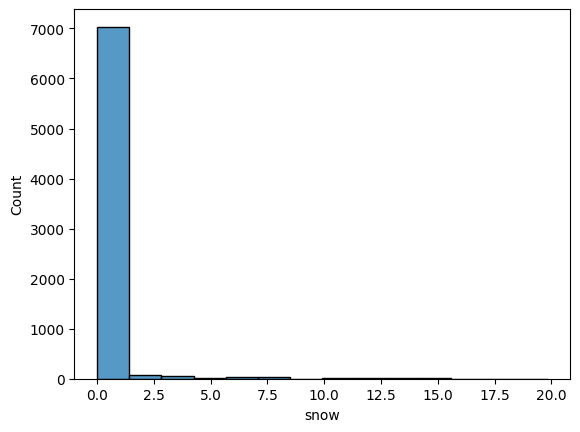

In [806]:
sns.histplot(data = df_all, x = 'snow')
plt.show()

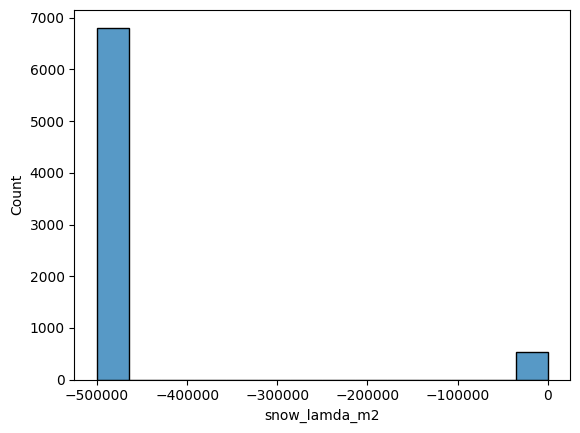

In [807]:
sns.histplot(data = df_all, x = 'snow_lamda_m2')
plt.show()

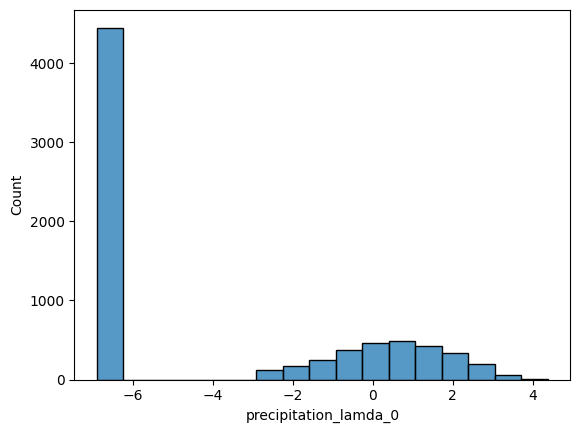

In [808]:
sns.histplot(data = df_all, x = 'precipitation_lamda_0')
plt.show()

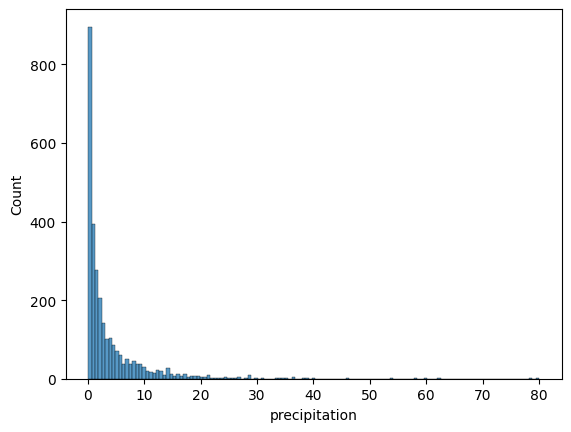

In [809]:
sns.histplot(data = df_all[df_all['precipitation']!=0], x = 'precipitation')
plt.show()

In [810]:
# show categorical columns
df_all.select_dtypes(include = 'object').columns

Index(['holiday_name', 'id', 'warehouse'], dtype='object')

In [811]:
# print columns that have only one unique value
for col in df_all.columns:
  if len(df_all[col].unique()) == 1:
    print(col)

warehouse_limited


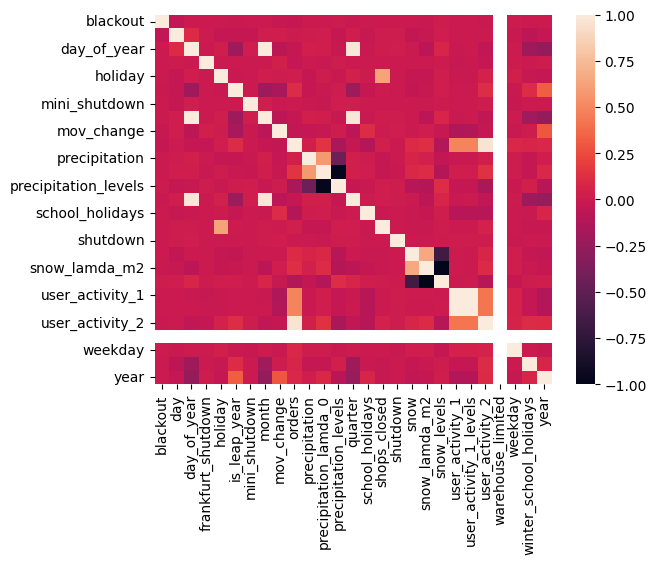

In [812]:
df_corr = df_all.select_dtypes(include = 'number').corr()
sns.heatmap(data = df_corr)
plt.show()

In [813]:
df_corr[df_corr > 0.7]

,blackout,day,day_of_year,frankfurt_shutdown,holiday,is_leap_year,mini_shutdown,month,mov_change,orders,...,snow,snow_lamda_m2,snow_levels,user_activity_1,user_activity_1_levels,user_activity_2,warehouse_limited,weekday,winter_school_holidays,year
blackout,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
day,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
day_of_year,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,0.996789,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
frankfurt_shutdown,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
holiday,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
is_leap_year,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mini_shutdown,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
month,NaN,NaN,0.996789,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mov_change,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
orders,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,...,NaN,NaN,NaN,NaN,NaN,0.960245,NaN,NaN,NaN,NaN


**Observations**
- precipitation vs orders (transform: boxcox)
- snow vs orders (transform: boxcox)
- user_activity_1 vs orders (transform: boxcox - weird function)

## Outputs

In [815]:
# save all data
filepath1 = data_folder + 'all_train.csv'
df_all.to_csv(path_or_buf = filepath1, header = True, index = False)